In [ ]:
%matplotlib inline
!pip install torchaudio # 安装pytorch

     |████████████████████████████████| 3.2MB 4.8MB/s 



torchaudio Tutorial
===================
本篇中文注解来源：[pytorch中文文档](https://pytorch.apachecn.org/docs/1.4/15.html#sphx-glr-download-beginner-audio-preprocessing-tutorial-py)
源文档：[pytorchaudio](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)

pyTorch 是一个开源深度学习平台，提供了从研究原型到具有 GPU 支持的生产部署的无缝路径。

解决机器学习问题的巨大努力在于数据准备。 torchaudio充分利用了 PyTorch 的 GPU 支持，并提供了许多工具来简化数据加载并使其更具可读性。 在本教程中，我们将看到如何从简单的数据集中加载和预处理数据。

对于本教程，请确保已安装matplotlib软件包，以便于查看。




In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

打开文件
-----------------

``torchaudio`` 还支持以 wav 和 mp3 格式加载声音文件。 我们将波形称为原始音频信号。




波形形状: torch.Size([2, 1016768])
波形采样率: 44100


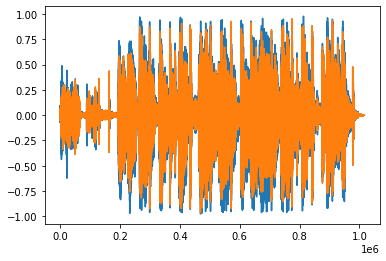

In [ ]:
filename = "/content/wav/1.wav"
waveform, sample_rate = torchaudio.load(filename)

print("波形形状: {}".format(waveform.size()))
print("波形采样率: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

在`torchaudio`中加载文件时，可以选择指定后端以通过`torchaudio.set_audio_backend`使用 SoX 或 SoundFile 。 这些后端在需要时会延迟加载。

`torchaudio` 还使 JIT 编译对于功能是可选的，并在可能的情况下使用`nn.Module`。


转化
---------------

torchaudio支持不断增长的转换列表。

- 重采样：将波形重采样为其他采样率。
- 频谱图：从波形创建频谱图。
- GriffinLim ：使用 Griffin-Lim 转换从线性比例幅度谱图计算波形。
- ComputeDeltas ：计算张量(通常是声谱图）的增量系数。
- ComplexNorm ：计算复数张量的范数。
- MelScale ：使用转换矩阵将正常 STFT 转换为 Mel 频率 STFT。
- AmplitudeToDB ：这将频谱图从功率/振幅标度变为分贝标度。
- MFCC ：根据波形创建梅尔频率倒谱系数。
- MelSpectrogram ：使用 PyTorch 中的 STFT 功能从波形创建 MEL 频谱图。
- MuLawEncoding ：基于 mu-law 压扩对波形进行编码。
- MuLawDecoding ：解码 mu-law 编码波形。
- TimeStretch ：在不更改给定速率的音高的情况下，及时拉伸频谱图。
- FrequencyMasking ：在频域中对频谱图应用屏蔽。
- TimeMasking ：在时域中对频谱图应用屏蔽。

每个变换都支持批处理：您可以对单个原始音频信号或频谱图或许多相同形状的信号执行变换。

由于所有变换都是`nn.Modules或jit.ScriptModules`，因此它们可以随时用作神经网络的一部分。

首先，我们可以以对数刻度查看频谱图的对数。




谱图形状: torch.Size([2, 201, 5084])


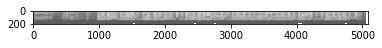

In [ ]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("谱图形状: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

或者我们可以以对数刻度查看梅尔光谱图。

谱图形状: torch.Size([2, 128, 5084])


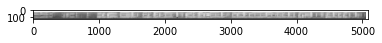

In [ ]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("谱图形状: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

我们可以一次对一个通道重新采样波形。

变换波形形状: torch.Size([1, 101677])


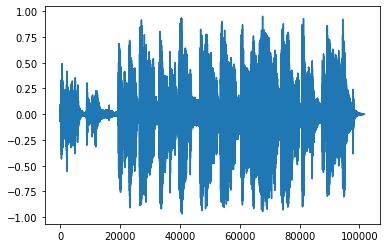

In [ ]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("变换波形形状: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

作为变换的另一个示例，我们可以基于 Mu-Law 编码对信号进行编码。 但是要做到这一点，我们需要信号在-1 和 1 之间。由于张量只是一个常规的 PyTorch 张量，因此我们可以在其上应用标准运算符。

In [ ]:
# Let's check if the tensor is in the interval [-1,1]
print("最小波形: {}\n最大波形: {}\n波形平均值: {}".format(waveform.min(), waveform.max(), waveform.mean()))

最小波形: -0.975921630859375
最大波形: 0.978302001953125
波形平均值: 0.0024319591466337442


由于波形已经在-1 和 1 之间，因此我们不需要对其进行归一化。

In [ ]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

让我们对波形进行编码。

变换波形形状: torch.Size([2, 1016768])


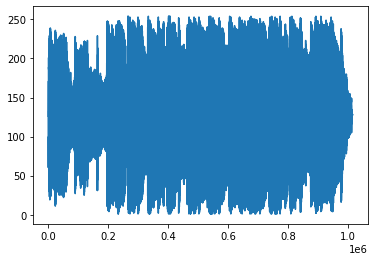

In [ ]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("变换波形形状: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

现在解码。

恢复波形形状: torch.Size([2, 1016768])


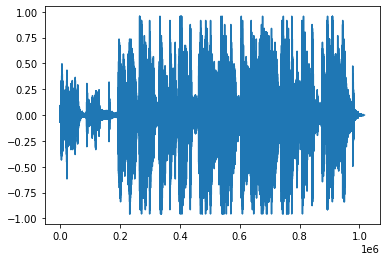

In [ ]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("恢复波形形状: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

我们最终可以将原始波形与其重建版本进行比较。

In [ ]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("原始信号和MuLaw重建信号的相对差值中值: {:.2%}".format(err))

原始信号和MuLaw重建信号的相对差值中值: 1.24%


Functional
---------------

上面看到的转换依赖于较低级别的无状态函数进行计算。 这些功能在torchaudio.functional下可用。 完整列表位于，此处为，包括：

- istft ：短时傅立叶逆变换。
- 增益：对整个波形进行放大或衰减。
- 抖动：增加以特定位深度存储的音频的动态范围。
- compute_deltas ：计算张量的增量系数。
- equalizer_biquad ：设计双二阶峰均化器滤波器并执行滤波。
- lowpass_biquad ：设计双二阶低通滤波器并执行滤波。
- highpass_biquad ：设计双二阶高通滤波器并执行滤波。

例如，让我们尝试 <cite>mu_law_encoding</cite> 功能：



变换波形形状: torch.Size([2, 1016768])


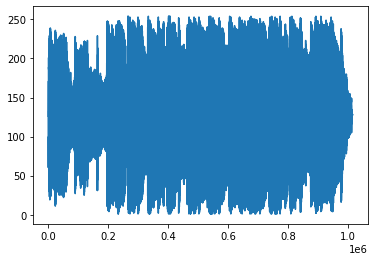

In [ ]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("变换波形形状: {}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy())

您可以看到从``torchaudio.functional.mu_law_encoding``的输出与从``torchaudio.transforms.MuLawEncoding``的输出相同。

现在，让我们尝试其他一些功能并将其输出可视化。 通过我们的频谱图，我们可以计算出其增量：



计算的函数的形状: torch.Size([2, 128, 5084])


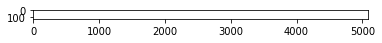

In [ ]:
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("计算的函数的形状: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

我们可以获取原始波形并对其应用不同的效果。

In [ ]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("最小增益波形: {}\n最大增益波形: {}\n增益波形平均值: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("最小干扰波形: {}\n最大干扰波形: {}\n干扰波形平均值: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

最小增益波形: -1.7354613542556763
最大增益波形: 1.739694356918335
增益波形平均值: 0.004324703942984343
最小干扰波形: -0.975830078125
最大干扰波形: 0.978240966796875
干扰波形平均值: 0.0024459294509142637


``torchaudio.functional``中功能的另一个示例是将滤波器应用于我们的波形。 将低通双二阶滤波器应用于我们的波形，将输出修改了频率信号的新波形。



最小低通波: -0.9601297378540039
最大低通波: 0.9587850570678711
低通波平均值: 0.0024319570511579514


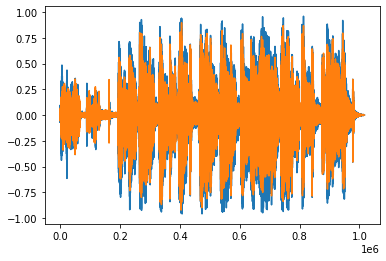

In [ ]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("最小低通波: {}\n最大低通波: {}\n低通波平均值: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

我们还可以使用高通双二阶滤波器可视化波形。

最小高通波: -0.8485786318778992
最大高通波: 0.8338438868522644
高通波平均值: 6.002860014620026e-11


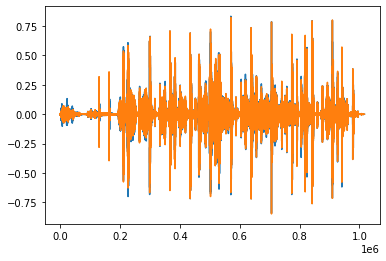

In [ ]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("最小高通波: {}\n最大高通波: {}\n高通波平均值: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

从 Kaldi 迁移到 Torchaudio
----------------------------------

用户可能熟悉 Kaldi (一种用于语音识别的工具包）。 torchaudio提供与torchaudio.kaldi_io中的兼容性。 实际上，它可以通过以下方式从 kaldi scp 或 ark 文件或流中读取：

- read_vec_int_ark
- read_vec_flt_scp
- read_vec_flt_arkfile / stream
- read_mat_scp
- read_mat_ark
`torchaudio`为`spectrogra`m，`fbank`，`mfcc`和提供 Kaldi 兼容的转换。 resample_waveform 受益于 GPU 支持。




Shape of spectrogram: torch.Size([5082, 201])


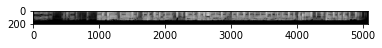

In [ ]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("光谱图: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

我们还支持根据波形计算滤波器组功能，以匹配 Kaldi 的实现。

Shape of fbank: torch.Size([5082, 23])


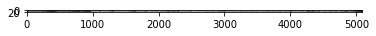

In [ ]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')

您可以从原始音频信号创建梅尔频率倒谱系数，这与 Kaldi 的 compute-mfcc-feats 的输入/输出相匹配。

Shape of mfcc: torch.Size([5082, 13])


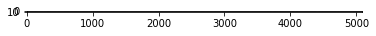

In [ ]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='gray')

可用数据集
-----------------

如果您不想创建自己的数据集来训练模型，则torchaudio提供了统一的数据集界面。 该接口支持将文件延迟加载到内存，下载和提取函数以及数据集以构建模型。

当前支持的数据集torchaudio为：

- VCTK ：109 位以英语为母语的母语者发出的语音数据，带有各种重音(在此处详细了解）。
- 是或否：一个人在希伯来语中说是或否的 60 张录音； 每个记录长 8 个字(此处更多信息）。
- 通用语音：开源的多语言语音数据集，任何人都可以用来训练启用语音的应用程序(在此处了解更多）。
- LibriSpeech ：阅读英语语音的大型语料库(1000 小时）(在此处详细了解）。





Waveform: tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.0071e-03,
         -1.2207e-03, -8.5449e-04]])
Sample rate: 8000
Labels: [0, 0, 1, 0, 0, 1, 1, 0]


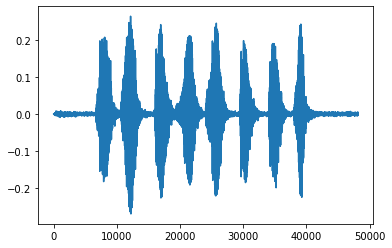

In [ ]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy())

现在，每当您从数据集中请求声音文件时，仅当您请求声音文件时，它才会加载到内存中。 意思是，数据集仅加载您想要和使用的项目并将其保留在内存中，并保存在内存中。

结论
----------

我们使用示例原始音频信号或波形来说明如何使用torchaudio打开音频文件，以及如何对该波形进行预处理，转换和应用功能。 我们还演示了如何使用熟悉的 Kaldi 函数以及如何使用内置数据集来构建模型。 鉴于torchaudio是基于 PyTorch 构建的，因此这些技术可在利用 GPU 的同时，用作更高级音频应用(例如语音识别）的构建块。


